In [40]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import utils

X, y = utils.load_dow_jones_index()
print(X)
# set global drawing parameters
plt.rcParams.update({
    'font.size': 14,
    'lines.linewidth': 2,
    'lines.markersize': 8
})


     quarter stock       date    open    high     low   close     volume  \
0          1    AA   1/7/2011  $15.82  $16.72  $15.78  $16.42  239655616   
1          1    AA  1/14/2011  $16.71  $16.71  $15.64  $15.97  242963398   
2          1    AA  1/21/2011  $16.19  $16.38  $15.60  $15.79  138428495   
3          1    AA  1/28/2011  $15.87  $16.63  $15.82  $16.13  151379173   
4          1    AA   2/4/2011  $16.18  $17.39  $16.18  $17.14  154387761   
..       ...   ...        ...     ...     ...     ...     ...        ...   
745        2   XOM  5/27/2011  $80.22  $82.63  $80.07  $82.63   68230855   
746        2   XOM   6/3/2011  $83.28  $83.75  $80.18  $81.18   78616295   
747        2   XOM  6/10/2011  $80.93  $81.87  $79.72  $79.78   92380844   
748        2   XOM  6/17/2011  $80.00  $80.82  $78.33  $79.02  100521400   
749        2   XOM  6/24/2011  $78.65  $81.12  $76.78  $76.78  118679791   

     percent_change_price  percent_change_volume_over_last_wk  \
0                 3.79

In [41]:
cols_to_convert = [
    'open', 'high', 'low', 'close', 'volume',
    'percent_change_price', 'percent_change_volume_over_last_wk',
    'previous_weeks_volume', 'next_weeks_open', 'next_weeks_close',
    'days_to_next_dividend', 'percent_return_next_dividend'
]

# remove '$' and ',' from each column and convert them to numerical values
for col in cols_to_convert:
    X[col] = X[col].astype(str).str.replace(r'[\$,]', '', regex=True)
    X[col] = pd.to_numeric(X[col], errors='coerce')

# date conversion
if 'date' in X.columns:
    X['date'] = pd.to_datetime(X['date'], errors='coerce')
else:
    X['date'] = pd.date_range(start='2000-01-01', periods=len(X), freq='W')

# sort by date
X.sort_values(by='date', inplace=True)

# get all stock codes
unique_stocks = sorted(X['stock'].unique())

# generate color mapping based on the number of stocks
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_stocks)))
color_dict = dict(zip(unique_stocks, colors))

start_limit = pd.to_datetime("2011-01-01")
end_limit = pd.to_datetime("2011-07-02")
unique_dates = np.array(sorted(X['date'].unique()))
ticks = unique_dates[(unique_dates >= start_limit) & (unique_dates <= end_limit)]
ticks = pd.to_datetime(ticks).to_pydatetime().tolist()

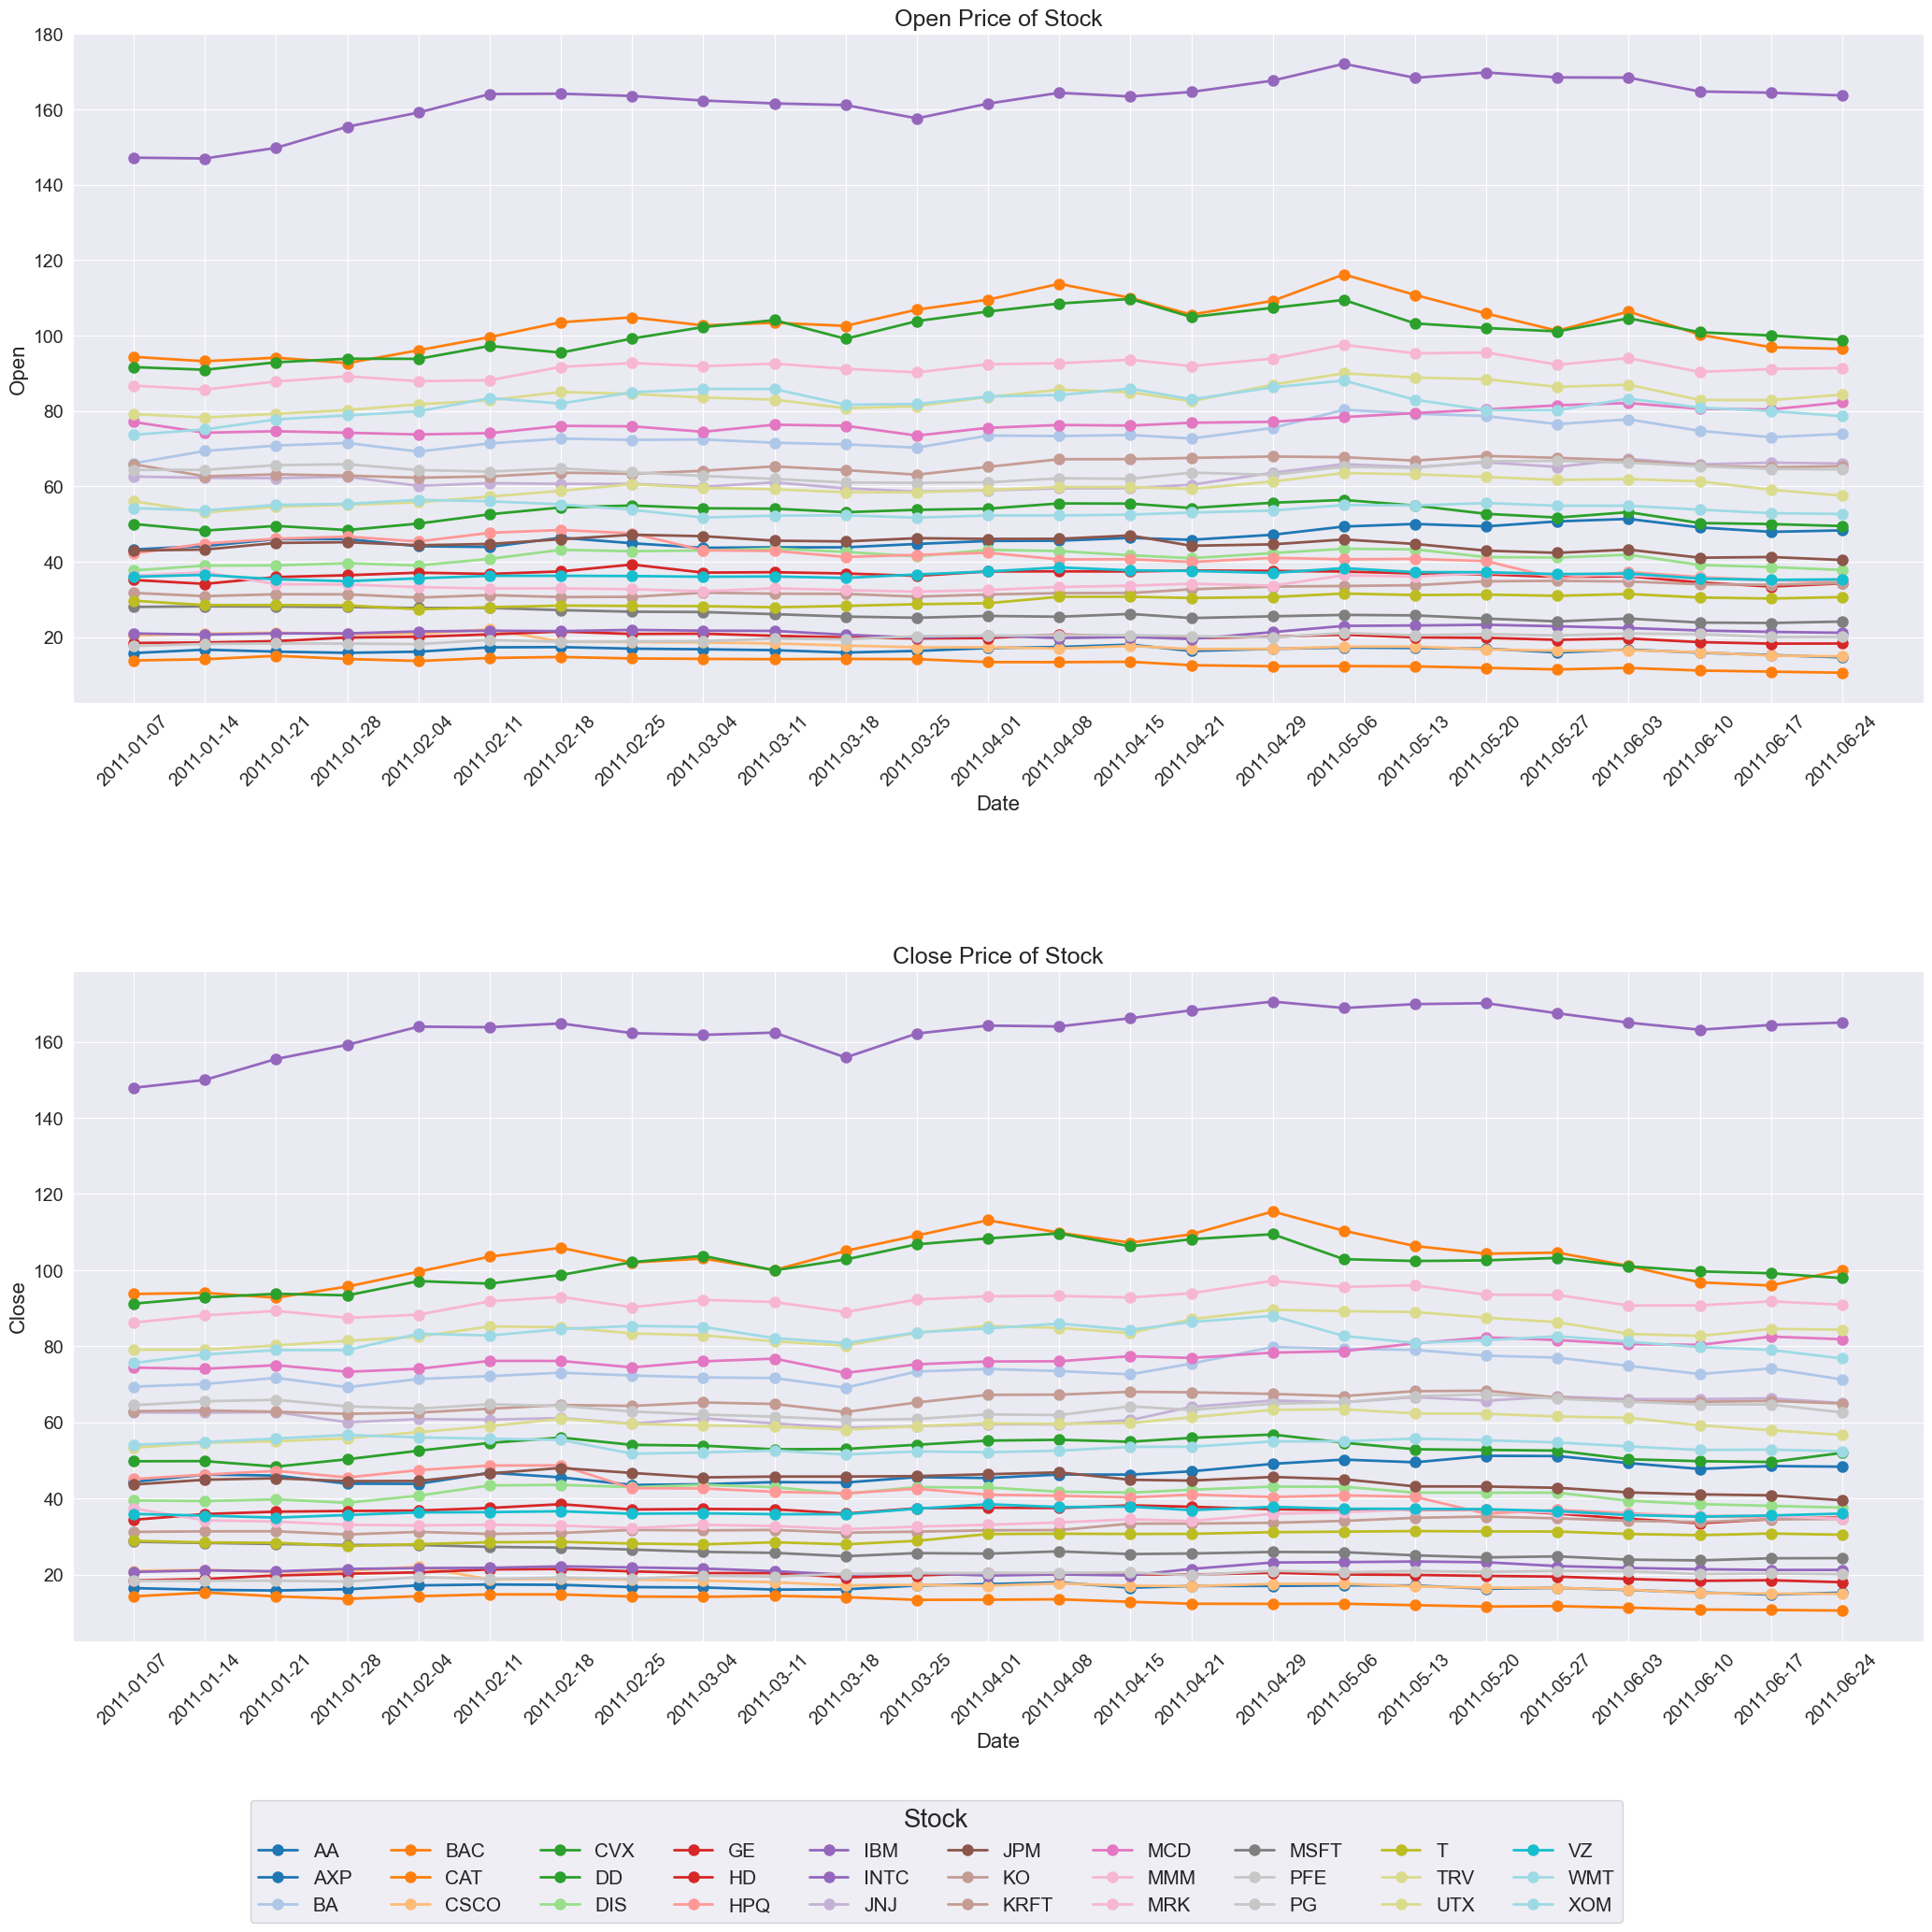

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(22, 20))

for stock in unique_stocks:
    stock_data = X[X['stock'] == stock]

    ax1.plot(stock_data['date'], stock_data['open'], marker='o',
             label=stock, color=color_dict[stock])

    ax2.plot(stock_data['date'], stock_data['close'], marker='o',
             label=stock, color=color_dict[stock])

ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Open', fontsize=16)
ax1.set_title('Open Price of Stock', fontsize=18)
ax1.set_xlim(start_limit, end_limit)
ax1.set_xticks(ticks)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.tick_params(axis='x', rotation=45)

ax2.set_xlabel('Date', fontsize=16)
ax2.set_ylabel('Close', fontsize=16)
ax2.set_title('Close Price of Stock', fontsize=18)
ax2.set_xlim(start_limit, end_limit)
ax2.set_xticks(ticks)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.tick_params(axis='x', rotation=45)

# add public legend
handles, labels = ax1.get_legend_handles_labels()
max_columns = 10
ncol = min(max_columns, len(unique_stocks))

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01),
           ncol=ncol, fontsize=15, title='Stock', title_fontsize=20)

plt.subplots_adjust(left=0.08, right=0.98, top=0.93, bottom=0.07, hspace=0.4)

plt.show()


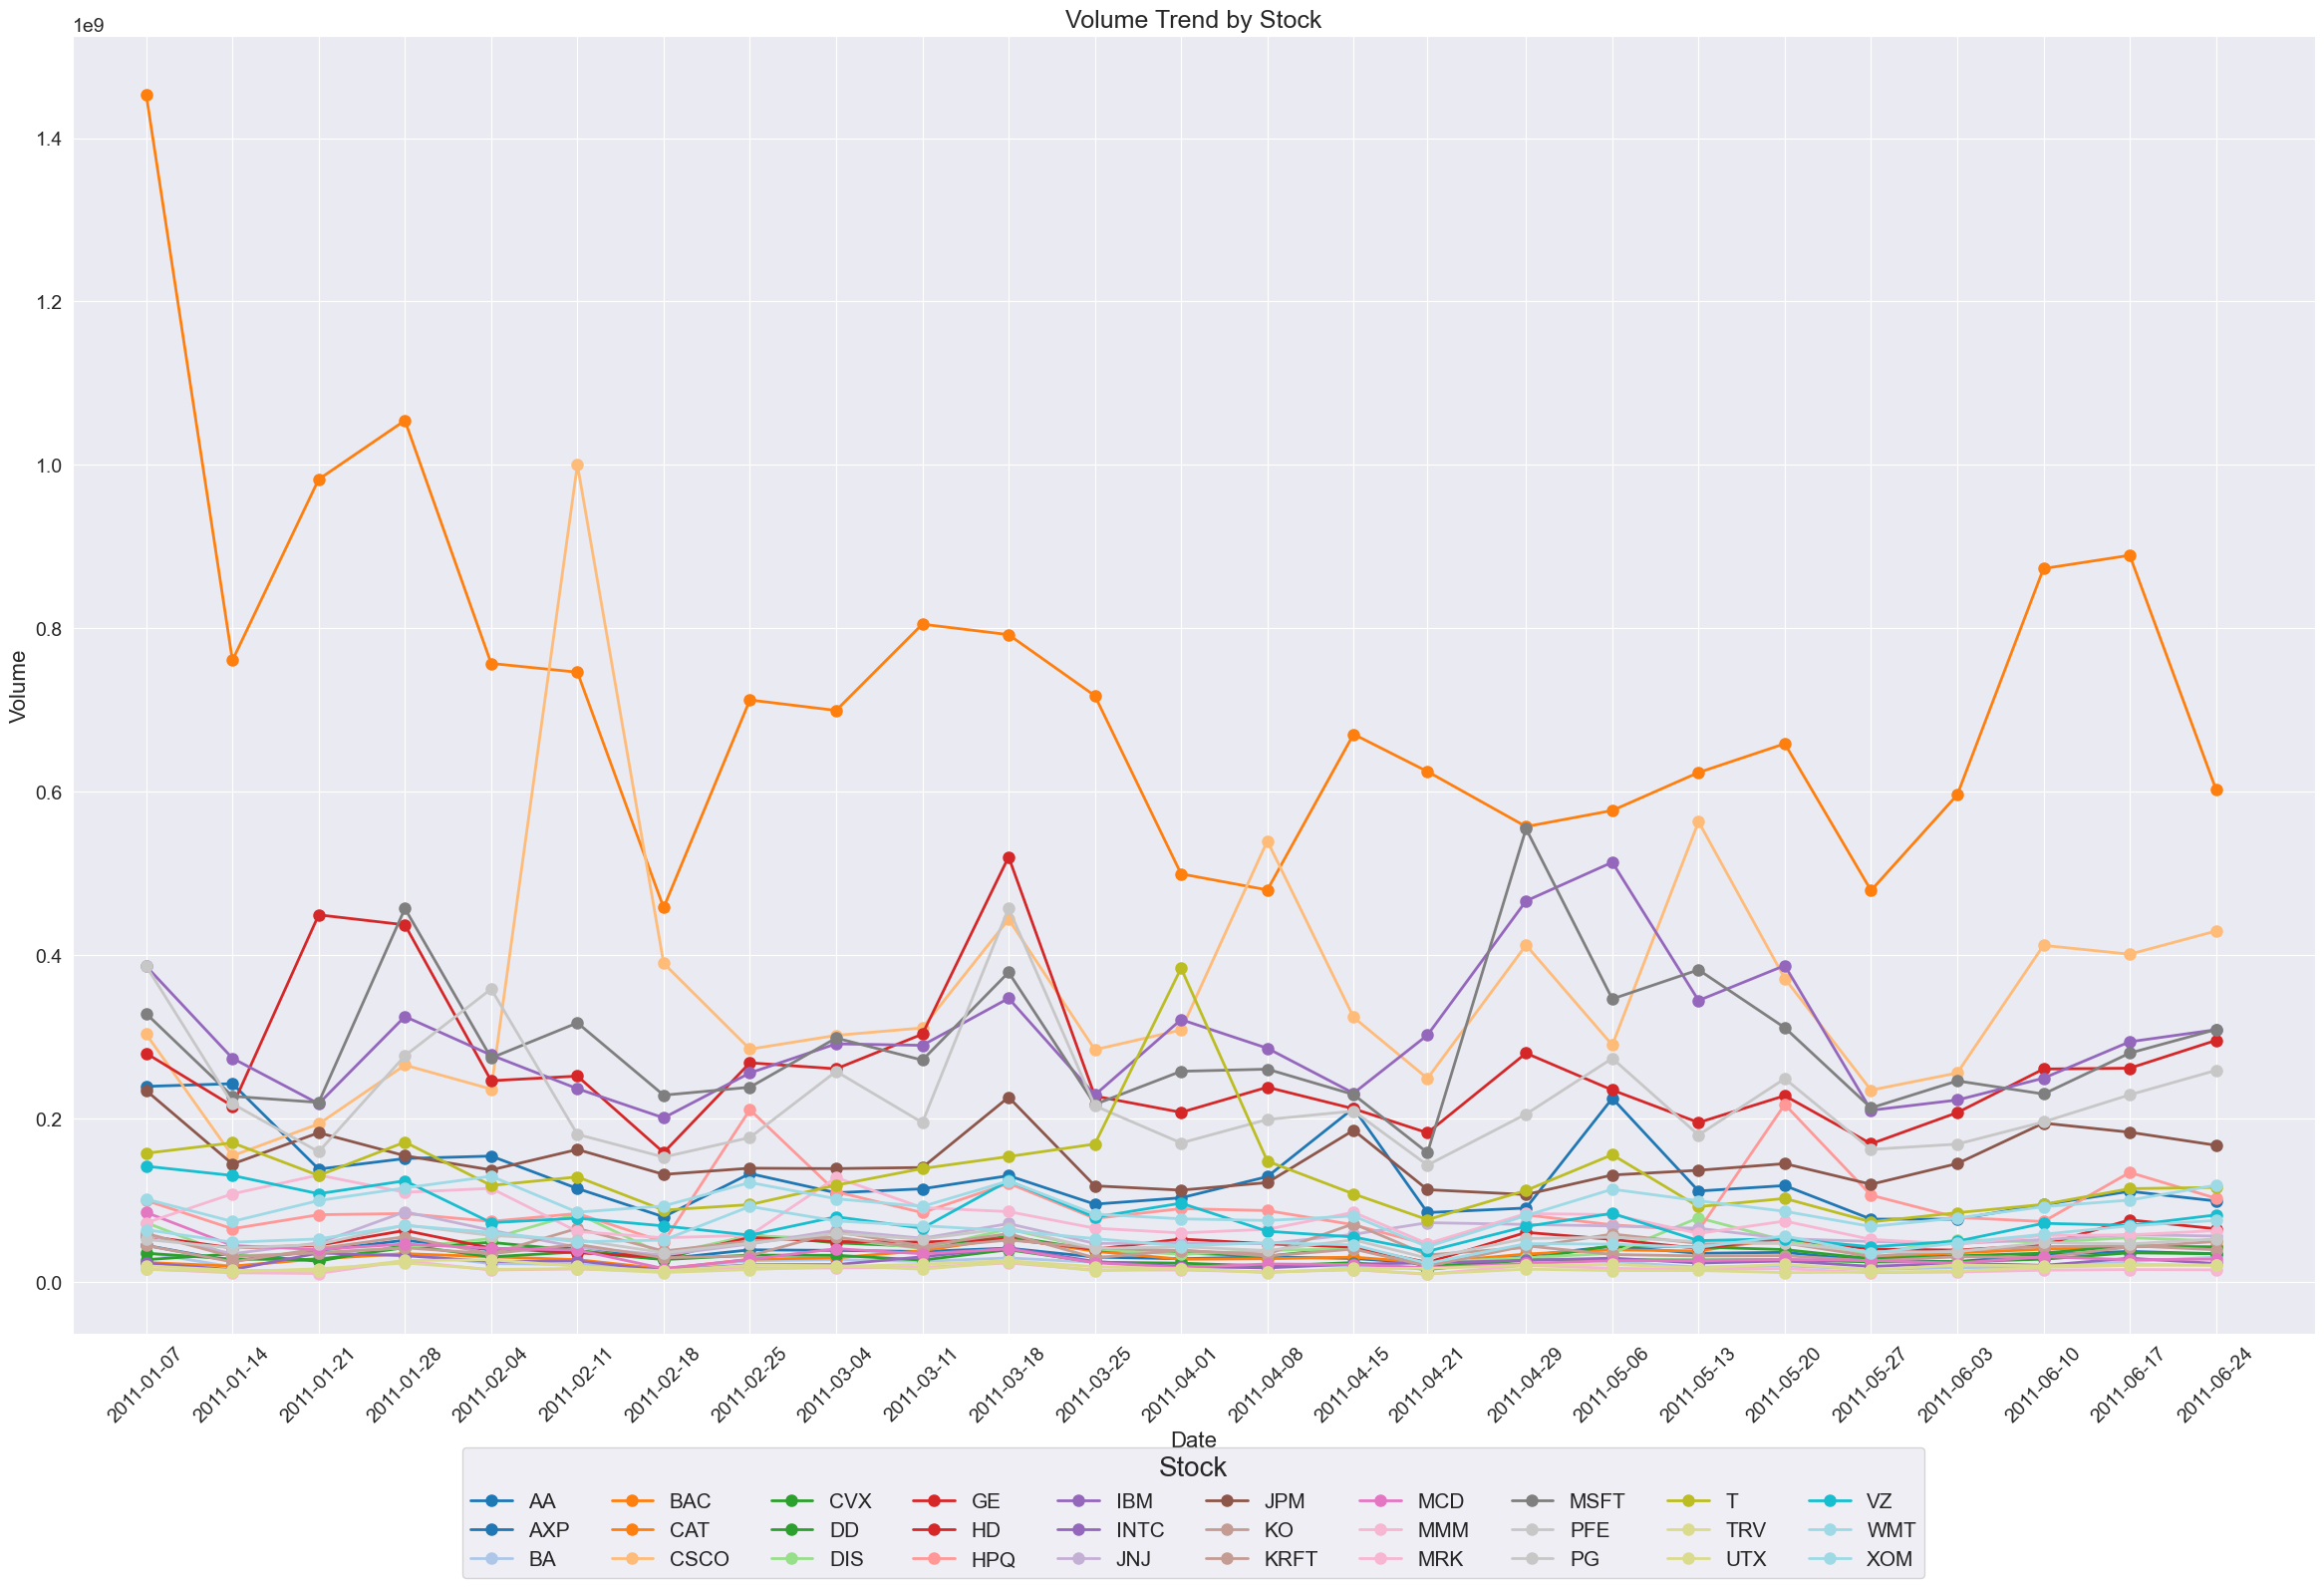

In [43]:
fig, ax1 = plt.subplots(figsize=(25, 14))

start_limit = pd.to_datetime("2011-01-01")
end_limit = pd.to_datetime("2011-07-02")
unique_dates = np.array(sorted(X['date'].unique()))
ticks = unique_dates[(unique_dates >= start_limit) & (unique_dates <= end_limit)]
ticks = pd.to_datetime(ticks).to_pydatetime().tolist()

for stock in unique_stocks:
    stock_data = X[X['stock'] == stock]
    ax1.plot(stock_data['date'], stock_data['volume'], marker='o', label=stock,
             color=color_dict[stock])

ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Volume', fontsize=16)
ax1.set_title('Volume Trend by Stock', fontsize=18)
ax1.set_xlim(start_limit, end_limit)
ax1.set_xticks(ticks)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.tick_params(axis='x', rotation=45)

max_columns = 10
ncol = min(max_columns, len(unique_stocks))
ax1.legend(title='Stock', loc='upper center',
           bbox_to_anchor=(0.5, -0.08),
           ncol=ncol, fontsize=15, title_fontsize=20)

plt.subplots_adjust(left=0.08, right=0.98, top=0.93, bottom=0)
plt.show()


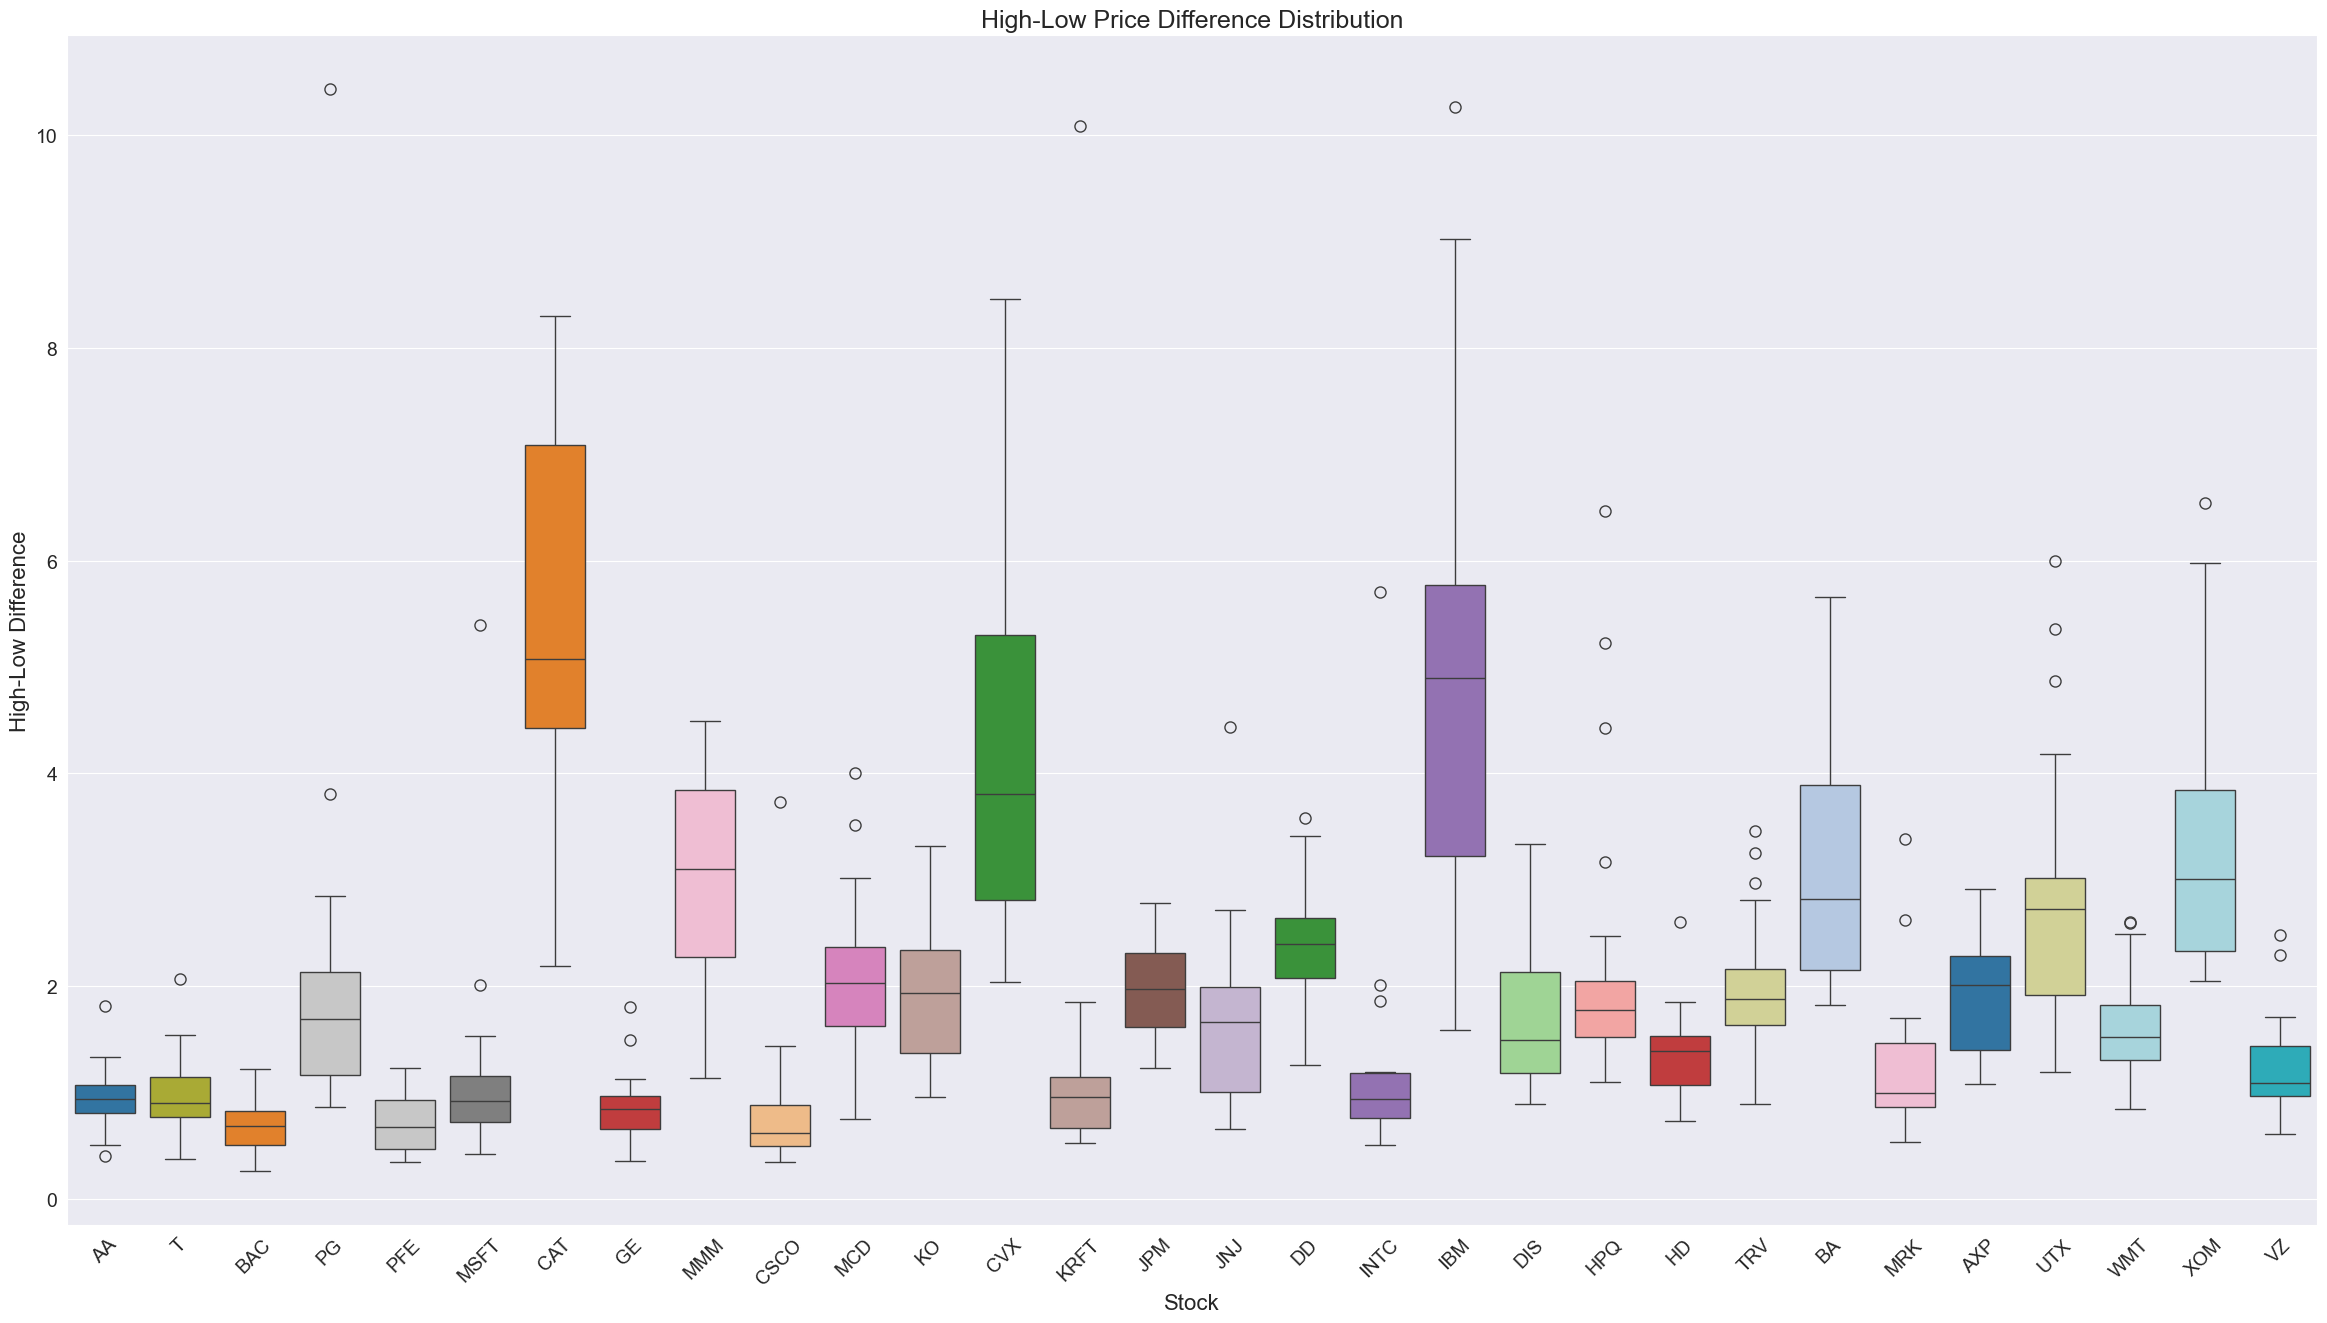

In [44]:
X['high_low_diff'] = X['high'] - X['low']

fig, ax = plt.subplots(figsize=(25, 14))

sns.boxplot(x='stock', y='high_low_diff', hue='stock',data=X, palette=color_dict, ax=ax)

ax.set_title('High-Low Price Difference Distribution', fontsize=18)
ax.set_xlabel('Stock', fontsize=16)
ax.set_ylabel('High-Low Difference', fontsize=16)

plt.xticks(rotation=45)

plt.subplots_adjust(left=0.08, right=0.98, top=0.93, bottom=0.08)

plt.show()

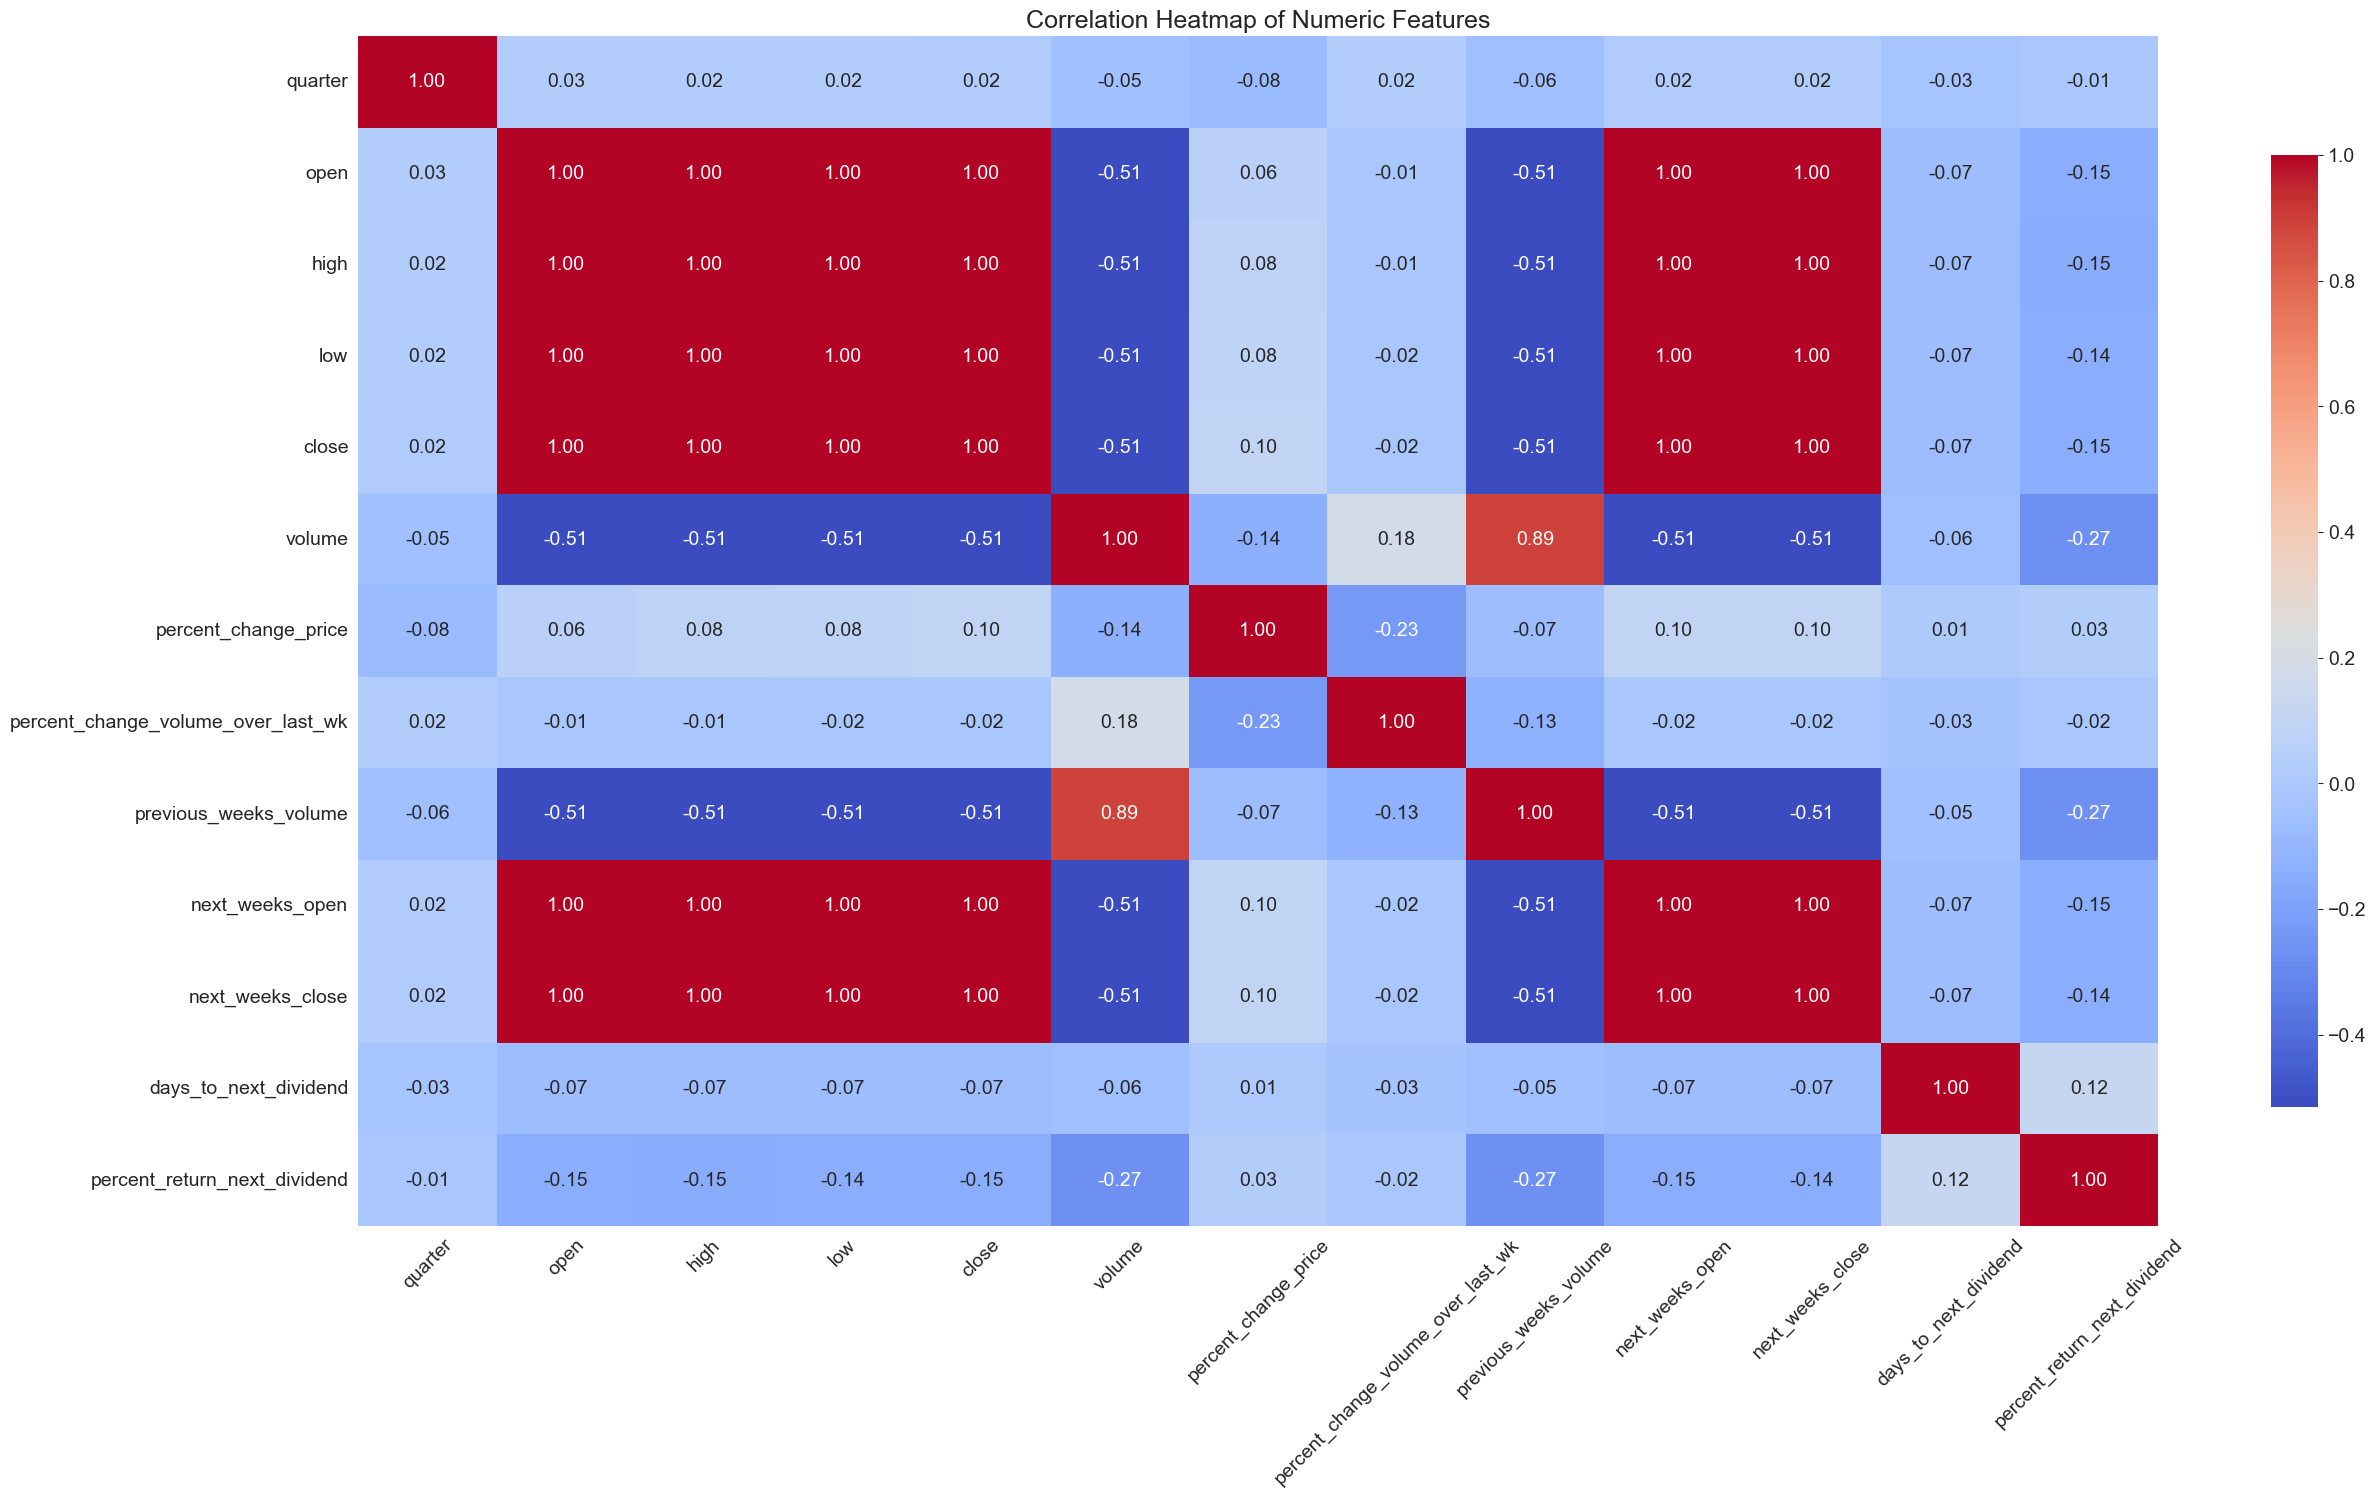

In [45]:
X1 = X.drop(columns=['quarter'])
X1 = X.drop(columns=['high_low_diff'])

numeric_cols = X1.select_dtypes(include=[np.number]).columns
corr_matrix = X1[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(25, 14))

heatmap = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": 0.8}, ax=ax)

ax.set_title('Correlation Heatmap of Numeric Features', fontsize=18)

plt.xticks(rotation=45)

plt.subplots_adjust(left=0.08, right=0.98, top=0.93, bottom=0.08)

plt.show()


In [46]:
# data processing
# The dataset as a whole is large, and the missing two samples have little impact on the overall analysis
# so just delete the rows with the missing values

X_clean = X.dropna(subset=['percent_change_volume_over_last_wk', 'previous_weeks_volume']).copy()
y_clean = y.loc[X_clean.index]

# df = df.dropna(subset=['percent_change_volume_over_last_wk', 'previous_weeks_volume'])


selected_features = [
    'quarter',
    'percent_change_price',
    'percent_change_volume_over_last_wk',
    'volume',
    'previous_weeks_volume',
    'days_to_next_dividend',
    'percent_return_next_dividend',
]

# 计算衍生特征
X_clean['volume_ratio'] = X_clean['volume'] / X_clean['previous_weeks_volume']
X_clean['price_range'] = X_clean['high'] - X_clean['low']

# 更新特征列表，将新特征加入其中
selected_features += ['volume_ratio', 'price_range']

# 从 X 中提取出选定的列
X_selected = X_clean[selected_features]
y_selected = y_clean
# 保存为 CSV 文件
X_selected.to_csv('clean_data.csv', index=False)
y_selected.to_csv('clean_targets.csv', index=False)

